<a href="https://colab.research.google.com/github/wei-yuan/patent_classification/blob/master/BertFeatureVectorToCPCNumStat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: From The First Claim of Patent to CPC Number Statistics

## Environment Setup

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 462 kB 36.1 MB/s 


In [2]:
# You will use the AdamW optimizer from tensorflow/models.
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 44.8 MB/s 
     |████████████████████████████████| 237 kB 68.7 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 352 kB 60.9 MB/s 
     |████████████████████████████████| 47.8 MB 41 kB/s 
     |████████████████████████████████| 99 kB 8.0 MB/s 
     |████████████████████████████████| 90 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 42.6 MB/s 
     |████████████████████████████████| 596 kB 43.3 MB/s 


## Import Library

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Load Pre-Trained Model of BERT from The Following Website

* BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
* Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [4]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


The preprocessing model

In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Load Test Text

In [6]:
claimString = ('A method for controlling an electronic apparatus, '
            + 'the method comprising: receiving image data, '
            + "an artificial intelligence (AI) flag indicating whether AI downscaling is performed by an external server, "
            + "and a filter index from the external server; decoding the image data; "
            + "in response to the AI flag being a first value and the filter index being not null, "
            + "upscaling the decoded image data using a first AI model corresponding to the filter index and providing the upscaled image data for output; "
            + "in response to the AI flag being the first value and the filter index being null, " 
            + "upscaling the decoded image data using a default AI model and providing the upscaled image data for output; " 
            + "and in response to the AI flag being not the first value, providing the decoded image data for output without performing an upscaling process, " 
            + "wherein the image data is obtained by encoding downscaled image data acquired " 
            + "by inputting original image data corresponding to the image data into a second AI model for downscaling original image data, " 
            + "wherein a number of filters of the first AI model is smaller than a number of filters of the second AI model, " 
            + "and wherein the first AI model is a Convolutional Neural Network (CNN).")

claimString = claimString.lower()
print(claimString)

a method for controlling an electronic apparatus, the method comprising: receiving image data, an artificial intelligence (ai) flag indicating whether ai downscaling is performed by an external server, and a filter index from the external server; decoding the image data; in response to the ai flag being a first value and the filter index being not null, upscaling the decoded image data using a first ai model corresponding to the filter index and providing the upscaled image data for output; in response to the ai flag being the first value and the filter index being null, upscaling the decoded image data using a default ai model and providing the upscaled image data for output; and in response to the ai flag being not the first value, providing the decoded image data for output without performing an upscaling process, wherein the image data is obtained by encoding downscaled image data acquired by inputting original image data corresponding to the image data into a second ai model for d

Check The Output Of Test Text

In [7]:
text_test = [claimString]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1037  4118  2005  9756  2019  4816 14709  1010  1996  4118  9605]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Generate Feature Vector from Test Text

In [8]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [9]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9529026   0.4219553  -0.30200574  0.25369307  0.41103554  0.9101889
  0.98970896 -0.42582595 -0.85301536 -0.6909152  -0.5641822  -0.60431534]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2696787   0.19009264 -0.5813089  ... -1.064227   -0.33731985
   1.2052773 ]
 [-0.5617293   0.6367726  -0.71991426 ... -0.15618807 -0.8970587
   0.68031204]
 [-0.6592194  -0.33713567 -0.17581698 ... -0.11071557  0.22451127
   0.5562562 ]
 ...
 [-0.3303348   0.18929352 -1.1435108  ... -1.3680383   0.8534971
  -0.40809566]
 [-0.8325043  -0.0549965   0.79068685 ... -0.22852856  0.5220612
  -0.3183328 ]
 [-0.4617275   0.04604169 -1.0418926  ...  0.12435531  0.52764994
   0.78420806]]


Mount Drive

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Read CSV

In [11]:
import pandas as pd
pd.__version__

'1.3.5'

In [14]:
df = pd.read_csv('gdrive/My Drive/out_sourcing/patent_classification/processed_data/patent_info_50.csv')     
df.head()

,patent_name,patent_ID,claim1,cpc number,claim1_feature_vector,cluster
0,Electronic device including helical antenna,"11,322,848","An electronic device, comprising: a housing co...",H01Q 1/243 (20130101); H01Q 1/2208 (20130101);...,NaN,NaN
1,"Display device, user terminal device, method f...","11,321,040",A display device comprising: a communication i...,G06F 3/1423 (20130101); G11B 27/34 (20130101);...,NaN,NaN
2,Sensing device with fingerprint sensor,"11,320,941",A sensing device comprising: a sensor; a touch...,H03K 17/962 (20130101); H03H 17/0671 (20130101...,NaN,NaN
3,Electronic device including antenna module,"11,316,284","An electronic device, comprising: a housing co...",H01Q 21/065 (20130101); H01Q 1/02 (20130101); ...,NaN,NaN
4,Operating method of electronic device for func...,"11,314,898",An electronic device comprising: a housing inc...,G06V 40/1365 (20220101); G10L 15/22 (20130101)...,NaN,NaN


# Generate Feature Vector to column claim1_feature_vector

In [15]:
claim1_series = df["claim1"]
claim1_feature_vector_list = list()

for index, value in claim1_series.items():
    text_test = [value]
    text_preprocessed = bert_preprocess_model(text_test)
    bert_results = bert_model(text_preprocessed)
    claim1_feature_vector_list.append(bert_results["pooled_output"].numpy()[0])  # get only 1d vector 

In [16]:
print(f"the number of data in claim1 feature list: {len(claim1_feature_vector_list)}")
length = 5
for index, vector in enumerate(claim1_feature_vector_list, start = 1):
    print(f"the vector size: {vector.shape}")
    print(f"the {index} claim1 feature vector in only {length} digits: {vector[:length]}")

the number of data in claim1 feature list: 50
the vector size: (512,)
the 1 claim1 feature vector in only 5 digits: [0.9804177  0.09281336 0.06313156 0.08277915 0.9031602 ]
the vector size: (512,)
the 2 claim1 feature vector in only 5 digits: [ 0.7943135   0.92592    -0.15183617  0.05775909  0.696269  ]
the vector size: (512,)
the 3 claim1 feature vector in only 5 digits: [ 0.99273396 -0.00217227 -0.43584538  0.02674943  0.7071277 ]
the vector size: (512,)
the 4 claim1 feature vector in only 5 digits: [ 0.95712984  0.28703988 -0.03601776 -0.01548582  0.87454623]
the vector size: (512,)
the 5 claim1 feature vector in only 5 digits: [ 0.959633    0.67156535 -0.16828841  0.29993826  0.836939  ]
the vector size: (512,)
the 6 claim1 feature vector in only 5 digits: [ 0.9653515  -0.65629786 -0.11258493  0.2361003   0.8397746 ]
the vector size: (512,)
the 7 claim1 feature vector in only 5 digits: [ 0.877998   -0.12351528  0.12828426  0.4841077   0.7826838 ]
the vector size: (512,)
the 8 claim

# K-Means Clustering

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [18]:
from sklearn.cluster import KMeans

number_of_cluster = 5  # <--- input the number of clusters here
kmeans = KMeans(n_clusters = number_of_cluster)
kmeans.fit(claim1_feature_vector_list)
y_kmeans = kmeans.predict(claim1_feature_vector_list)

In [19]:
print(f"The class number after K-Means: {y_kmeans}")

The class number after K-Means: [0 3 1 4 4 1 1 3 2 2 0 3 1 4 0 2 1 3 4 3 3 0 1 3 3 4 4 4 3 0 3 1 4 4 2 2 1
 0 4 2 3 3 1 3 0 3 3 1 1 3]


# Dimensional Reduction For High Dimension Vector
The working flow: vector -> PCA -> tSNE

In [20]:
!pip install scprep phate umap-learn

     |████████████████████████████████| 104 kB 5.0 MB/s 
     |████████████████████████████████| 88 kB 5.5 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 416 kB 65.9 MB/s 
     |████████████████████████████████| 1.8 MB 34.4 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=3ae382b64091e8d4bd113d5f4df7a562e5eb1b33fdc0d45e0ade543bfd9878ae
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=3dfb826b2c3fa41b814d0dc151d9fe573177f53f52a86328a8042916d67678ef
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [21]:
import scprep

In [22]:
# Speed it up by running PCA to 50 dimensions.
data = np.array(claim1_feature_vector_list)
print(f"The data shape: {data.shape}")

# n_components must be between 0 and min(n_samples, n_features)=5
n_samples, n_features = data.shape[0], data.shape[1]
data_pca = scprep.reduce.pca(data, n_components=min(n_samples, n_features), method='dense')

The data shape: (50, 512)


Speed up t-SNE a little further by subsampling

In [23]:
import sklearn.manifold
tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


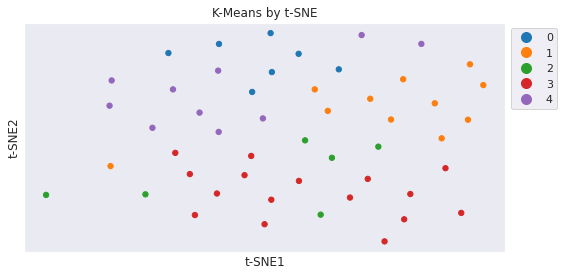

In [24]:
scprep.plot.scatter2d(data_tsne, c=y_kmeans,
                      figsize=(8,4), legend_anchor=(1,1),
                      ticks=False, label_prefix='t-SNE', 
                      title="K-Means by t-SNE")

Update New Series Data To Dataframe

In [25]:
c_series = pd.Series(claim1_feature_vector_list)
print(f"claim 1 feature vector: {c_series}")

claim 1 feature vector: 0     [0.9804177, 0.09281336, 0.06313156, 0.08277915...
1     [0.7943135, 0.92592, -0.15183617, 0.05775909, ...
2     [0.99273396, -0.0021722727, -0.43584538, 0.026...
3     [0.95712984, 0.28703988, -0.036017757, -0.0154...
4     [0.959633, 0.67156535, -0.16828841, 0.29993826...
5     [0.9653515, -0.65629786, -0.112584926, 0.23610...
6     [0.877998, -0.12351528, 0.12828426, 0.4841077,...
7     [0.92777634, 0.695498, -0.3336455, 0.29652742,...
8     [0.9674787, 0.26831323, -0.20602201, -0.017772...
9     [0.8841269, 0.06563699, -0.44831944, 0.1177656...
10    [0.98434407, -0.13348669, -0.054999013, 0.1469...
11    [0.9935299, 0.7482088, 0.027474264, 0.1860985,...
12    [0.9352643, 0.547526, -0.05781861, -0.02595526...
13    [0.88169456, 0.8645572, -0.10003983, -0.042966...
14    [0.97644275, -0.5111096, 0.028287381, 0.380252...
15    [0.98245925, 0.55498606, 0.06987757, 0.3463456...
16    [0.99462605, 0.38057032, -0.35860273, 0.075715...
17    [0.99018735, 0.949

In [26]:
# update claim 1 feature vector
df["claim1_feature_vector"] = c_series

In [27]:
print(df["claim1_feature_vector"])

0     [0.9804177, 0.09281336, 0.06313156, 0.08277915...
1     [0.7943135, 0.92592, -0.15183617, 0.05775909, ...
2     [0.99273396, -0.0021722727, -0.43584538, 0.026...
3     [0.95712984, 0.28703988, -0.036017757, -0.0154...
4     [0.959633, 0.67156535, -0.16828841, 0.29993826...
5     [0.9653515, -0.65629786, -0.112584926, 0.23610...
6     [0.877998, -0.12351528, 0.12828426, 0.4841077,...
7     [0.92777634, 0.695498, -0.3336455, 0.29652742,...
8     [0.9674787, 0.26831323, -0.20602201, -0.017772...
9     [0.8841269, 0.06563699, -0.44831944, 0.1177656...
10    [0.98434407, -0.13348669, -0.054999013, 0.1469...
11    [0.9935299, 0.7482088, 0.027474264, 0.1860985,...
12    [0.9352643, 0.547526, -0.05781861, -0.02595526...
13    [0.88169456, 0.8645572, -0.10003983, -0.042966...
14    [0.97644275, -0.5111096, 0.028287381, 0.380252...
15    [0.98245925, 0.55498606, 0.06987757, 0.3463456...
16    [0.99462605, 0.38057032, -0.35860273, 0.075715...
17    [0.99018735, 0.9491377, -0.014149559, 0.17

In [28]:
# update cluster number
df["cluster"] = y_kmeans

In [29]:
df.head(10)

,patent_name,patent_ID,claim1,cpc number,claim1_feature_vector,cluster
0,Electronic device including helical antenna,"11,322,848","An electronic device, comprising: a housing co...",H01Q 1/243 (20130101); H01Q 1/2208 (20130101);...,"[0.9804177, 0.09281336, 0.06313156, 0.08277915...",0
1,"Display device, user terminal device, method f...","11,321,040",A display device comprising: a communication i...,G06F 3/1423 (20130101); G11B 27/34 (20130101);...,"[0.7943135, 0.92592, -0.15183617, 0.05775909, ...",3
2,Sensing device with fingerprint sensor,"11,320,941",A sensing device comprising: a sensor; a touch...,H03K 17/962 (20130101); H03H 17/0671 (20130101...,"[0.99273396, -0.0021722727, -0.43584538, 0.026...",1
3,Electronic device including antenna module,"11,316,284","An electronic device, comprising: a housing co...",H01Q 21/065 (20130101); H01Q 1/02 (20130101); ...,"[0.95712984, 0.28703988, -0.036017757, -0.0154...",4
4,Operating method of electronic device for func...,"11,314,898",An electronic device comprising: a housing inc...,G06V 40/1365 (20220101); G10L 15/22 (20130101)...,"[0.959633, 0.67156535, -0.16828841, 0.29993826...",4
5,Display device and method of driving the same ...,"11,314,368","A display device, comprising: a display panel ...",G06F 3/0446 (20190501); G06F 3/0445 (20190501)...,"[0.9653515, -0.65629786, -0.112584926, 0.23610...",1
6,Touch apparatus and touch detection method the...,"11,314,361",A touch apparatus comprising: a touch panel th...,G06F 3/0445 (20190501); G06F 3/04162 (20190501...,"[0.877998, -0.12351528, 0.12828426, 0.4841077,...",1
7,Intelligent data collection and transmission b...,"11,313,938","A sensing device, comprising: an acoustic sens...",G01S 5/0027 (20130101); G01S 7/021 (20130101);...,"[0.92777634, 0.695498, -0.3336455, 0.29652742,...",3
8,Neuromodulation system and method for transiti...,"11,311,726",A neuromodulation system comprising: an extern...,A61N 1/37247 (20130101); A61N 1/36185 (2013010...,"[0.9674787, 0.26831323, -0.20602201, -0.017772...",2
9,Blood glucose measurement apparatus and blood ...,"11,311,214",A blood glucose measurement method performed b...,A61B 5/6833 (20130101); A61B 5/4809 (20130101)...,"[0.8841269, 0.06563699, -0.44831944, 0.1177656...",2


## Label Classification By Cluster Number

Pick cluster 0 as our observation target

In [30]:
# select cluster number
cluster_unique = df["cluster"].unique().tolist()
cluster_unique.sort()  # sort in the acsending way
print(f"cluster number: {cluster_unique}")

for cluster_num in cluster_unique:
    print(f"cluster number: {cluster_num}")
    single_cluster = df[df["cluster"] == cluster_num]
    break

cluster number: [0, 1, 2, 3, 4]
cluster number: 0


In [31]:
# check the result of cluster 0
single_cluster.head()

,patent_name,patent_ID,claim1,cpc number,claim1_feature_vector,cluster
0,Electronic device including helical antenna,"11,322,848","An electronic device, comprising: a housing co...",H01Q 1/243 (20130101); H01Q 1/2208 (20130101);...,"[0.9804177, 0.09281336, 0.06313156, 0.08277915...",0
10,Electronic device including electronic compone...,"11,310,400",An electronic device comprising: a housing inc...,H04N 5/2258 (20130101); H05K 1/028 (20130101);...,"[0.98434407, -0.13348669, -0.054999013, 0.1469...",0
14,Rollable electronic device including clearance...,"11,307,617",An electronic device comprising: a first housi...,G06F 1/1652 (20130101); G06F 1/1624 (20130101)...,"[0.97644275, -0.5111096, 0.028287381, 0.380252...",0
21,Power circuit and electronic device including ...,"11,296,518",An electronic device comprising: a housing: a ...,H01M 10/46 (20130101); H02J 7/0029 (20130101);...,"[0.9975851, 0.26239645, -0.16932125, -0.001700...",0
29,Electronic device,"11,287,554",An electronic device comprising: a housing com...,H04M 1/0264 (20130101); H05K 5/0017 (20130101)...,"[0.98669094, -0.33993125, -0.08795106, -0.0575...",0


CPC Number Category
* Section: F
* Class: F02
* Sub-class: F02D
* Group: F02D 41
* Sub-Group: F02D 41/02

In [32]:
# read each row data in cpc number
cpc_number_list = single_cluster["cpc number"].tolist()
print(f"Number of element in cpc_number_list: {len(cpc_number_list)}")
print(f"The content of cpc_number_list: {cpc_number_list}")

Number of element in cpc_number_list: 7
The content of cpc_number_list: ['H01Q 1/243 (20130101); H01Q 1/2208 (20130101); H01Q 1/38 (20130101); H01Q 11/08 (20130101)', 'H04N 5/2258 (20130101); H05K 1/028 (20130101); G06F 1/1626 (20130101); H04N 5/2252 (20130101); H04N 5/2257 (20130101); G06F 1/1686 (20130101); H05K 1/189 (20130101); H05K 2201/10356 (20130101); H05K 2201/10189 (20130101); H05K 2201/10151 (20130101); H05K 2201/10121 (20130101)', 'G06F 1/1652 (20130101); G06F 1/1624 (20130101); G06F 1/1656 (20130101)', 'H01M 10/46 (20130101); H02J 7/0029 (20130101); H02J 7/0024 (20130101); H02J 7/02 (20130101); H02J 7/0042 (20130101); H01M 10/441 (20130101); H01M 10/425 (20130101); H02J 7/0047 (20130101); H02J 7/0071 (20200101); H02J 7/0068 (20130101); H02J 7/0014 (20130101); H02J 2207/20 (20200101); H02J 2310/22 (20200101); H02J 7/0048 (20200101); H02J 50/10 (20160201); Y02E 60/10 (20130101); H01M 2010/4271 (20130101); H01M 2220/30 (20130101)', 'H04M 1/0264 (20130101); H05K 5/0017 (201301

In [33]:
def cpc_num_stat(mode: str, cpc_number_list: list, simple_cpc_number_dict: dict):    
    for row in cpc_number_list:
        # split by semi-colon
        row_split_by_semi =  row.split(';')
        for row in row_split_by_semi:        
            cpc_num_set = set()      
            # split by space
            row_split = row.split(' ')        
            row_split_filtered_empty_string = [x for x in row_split if x]
            # to sub-class level
            sub_class = row_split_filtered_empty_string[0]      
            # # to sub-group level
            sub_group = ' '.join(row_split_filtered_empty_string[:2])  # stop until the date information

            if MODE == 'SUB-CLASS':
                data = sub_class
            elif MODE == 'SUB-GROUP':
                data = sub_group

            # add to simple_cpc_number_dict          
            if sub_class not in simple_cpc_number_dict:
                simple_cpc_number_dict[data] = 1
            else:
                simple_cpc_number_dict[data] += 1
    return simple_cpc_number_dict

In [34]:
# switch mode here
MODE = 'SUB-CLASS'
stat_dictionary = dict()
result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)

Observe cluster Statistics in SUB-CLASS level

In [35]:
print(result)

{'H01Q': 4, 'H04N': 3, 'H05K': 8, 'G06F': 20, 'H01M': 5, 'H02J': 12, 'Y02E': 1, 'H04M': 5, 'G02B': 2, 'F21V': 2, 'H04B': 3}


Observe in finer grained SUB-GROUP level

In [36]:
# switch mode here
MODE = 'SUB-GROUP'
stat_dictionary = dict()
result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)

In [37]:
print(result)

{'H01Q 1/243': 1, 'H01Q 1/2208': 1, 'H01Q 1/38': 1, 'H01Q 11/08': 1, 'H04N 5/2258': 1, 'H05K 1/028': 1, 'G06F 1/1626': 1, 'H04N 5/2252': 1, 'H04N 5/2257': 1, 'G06F 1/1686': 1, 'H05K 1/189': 1, 'H05K 2201/10356': 1, 'H05K 2201/10189': 1, 'H05K 2201/10151': 1, 'H05K 2201/10121': 1, 'G06F 1/1652': 1, 'G06F 1/1624': 1, 'G06F 1/1656': 1, 'H01M 10/46': 1, 'H02J 7/0029': 1, 'H02J 7/0024': 1, 'H02J 7/02': 1, 'H02J 7/0042': 1, 'H01M 10/441': 1, 'H01M 10/425': 1, 'H02J 7/0047': 1, 'H02J 7/0071': 1, 'H02J 7/0068': 1, 'H02J 7/0014': 1, 'H02J 2207/20': 1, 'H02J 2310/22': 1, 'H02J 7/0048': 1, 'H02J 50/10': 1, 'Y02E 60/10': 1, 'H01M 2010/4271': 1, 'H01M 2220/30': 1, 'H04M 1/0264': 1, 'H05K 5/0017': 1, 'G02B 5/08': 1, 'F21V 7/00': 1, 'G06F 1/16': 1, 'G06F 1/1684': 1, 'F21V 14/003': 1, 'H05K 5/0217': 1, 'G02B 17/08': 1, 'H04M 1/026': 1, 'G06F 1/1681': 1, 'G06F 1/1641': 1, 'G06F 1/169': 1, 'G06F 1/1643': 1, 'G06F 3/03545': 1, 'G06F 1/1616': 1, 'G06F 1/1677': 1, 'G06F 1/1628': 1, 'H04B 5/0031': 1, 'H04M 

# iterate all class

In [38]:
# iterate each cluster number
for cluster_num in cluster_unique:
    print(f"cluster number: {cluster_num}")
    single_cluster = df[df["cluster"] == cluster_num]
    cpc_number_list = single_cluster["cpc number"].tolist()
    # switch mode here
    MODE = 'SUB-CLASS'
    stat_dictionary = dict()
    result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary) 
    print(f"CPC number stats in sub-class level: {result}")
    
    result = None
    # switch mode here
    MODE = 'SUB-GROUP'
    stat_dictionary = dict()
    result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)    
    print(f"CPC number stats in sub-group level: {result}\n")        

cluster number: 0
CPC number stats in sub-class level: {'H01Q': 4, 'H04N': 3, 'H05K': 8, 'G06F': 20, 'H01M': 5, 'H02J': 12, 'Y02E': 1, 'H04M': 5, 'G02B': 2, 'F21V': 2, 'H04B': 3}
CPC number stats in sub-group level: {'H01Q 1/243': 1, 'H01Q 1/2208': 1, 'H01Q 1/38': 1, 'H01Q 11/08': 1, 'H04N 5/2258': 1, 'H05K 1/028': 1, 'G06F 1/1626': 1, 'H04N 5/2252': 1, 'H04N 5/2257': 1, 'G06F 1/1686': 1, 'H05K 1/189': 1, 'H05K 2201/10356': 1, 'H05K 2201/10189': 1, 'H05K 2201/10151': 1, 'H05K 2201/10121': 1, 'G06F 1/1652': 1, 'G06F 1/1624': 1, 'G06F 1/1656': 1, 'H01M 10/46': 1, 'H02J 7/0029': 1, 'H02J 7/0024': 1, 'H02J 7/02': 1, 'H02J 7/0042': 1, 'H01M 10/441': 1, 'H01M 10/425': 1, 'H02J 7/0047': 1, 'H02J 7/0071': 1, 'H02J 7/0068': 1, 'H02J 7/0014': 1, 'H02J 2207/20': 1, 'H02J 2310/22': 1, 'H02J 7/0048': 1, 'H02J 50/10': 1, 'Y02E 60/10': 1, 'H01M 2010/4271': 1, 'H01M 2220/30': 1, 'H04M 1/0264': 1, 'H05K 5/0017': 1, 'G02B 5/08': 1, 'F21V 7/00': 1, 'G06F 1/16': 1, 'G06F 1/1684': 1, 'F21V 14/003': 1, 'H05